# Tutorial 1 - Driven Filter Circuit
This notebook is a simple tutorial on how to use the julia package ```BondGraphs``` to simulate a driven filter circuit.

This work is based on the Python tutorial for BondGraphTools, which can be found here: https://bondgraphtools.readthedocs.io/en/latest/tutorials/RC.html

In [1]:
# Since BondGraphs is not yet in the package manager, we will need to include it directly from Github
# using Pkg; Pkg.add(url="https://github.com/jedforrest/BondGraphs.git")
push!(LOAD_PATH, "C:/Users/jedfo/.julia/dev/BondGraphs/src/")
using BondGraphs

┌ Info: Precompiling BondGraphs [top-level]
└ @ Base loading.jl:1317
  ** incremental compilation may be fatally broken for this module **



In [2]:
using Plots
using ModelingToolkit

## Model Construction
We first create a `BondGraph` object which will hold all our components

In [3]:
model = BondGraph("RC")

BondGraph RC (0 Nodes, 0 Bonds)

We then create all the components of our model. Each component contains a constitutive equation which builds our model

In [4]:
C = Component(:C)
equations(C)

2-element Vector{Equation}:
 0 ~ q(t) / C - E[1](t)
 Differential(t)(q(t)) ~ F[1](t)

In [5]:
R = Component(:R)
equations(R)

1-element Vector{Equation}:
 0 ~ E[1](t) - R*F[1](t)

We also create an `EqualEffort` node which represents a shared effort (Force, Voltage etc.) between components

In [6]:
zero_law = EqualEffort()

𝟎

Components and nodes are added to the model, and connected together much like in a graph network

In [7]:
add_node!(model, [C, R, zero_law])
connect!(model, R, zero_law)
connect!(model, C, zero_law)
model

BondGraph RC (3 Nodes, 2 Bonds)

We can view our model structure by plotting the bond graph as a graph network

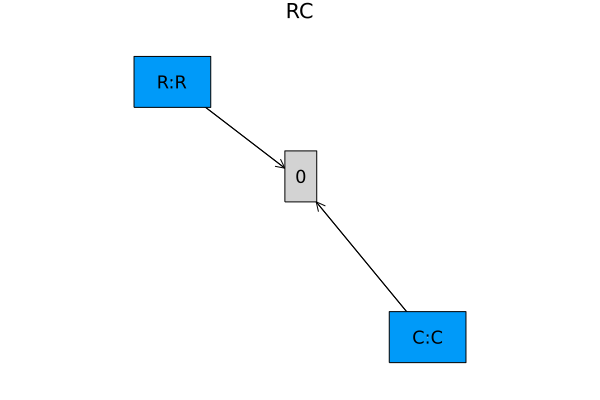

In [8]:
plot(model, fontsize=12)

## Simulating our Model
With a bond graph we can automatically generate a series of differential equations which combine all the constitutive relations from the components, with efforts and flows shared according to the graph structure.

In [9]:
constitutive_relations(model)

1-element Vector{Equation}:
 Differential(t)(C₊q(t)) ~ (-C₊q(t)) / (C₊C*R₊R)

We set values for parameters in the graph model itself. Each component comes with default values already.

In [10]:
C.C = 1
R.R = 1

1

Once our model is ready and fully parameritized, we can turn it into an ODESystem (or equivalent), which can be used by ModelingToolkit.jl however we like.

In [11]:
sys = ODESystem(model)
display("text/plain", sys)

Model RC with 1 equations
States (1):
  C₊q(t) [defaults to 0.0]
Parameters (2):
  C₊C [defaults to 1]
  R₊R [defaults to 1]
Incidence matrix:
 ×  ×

Alternatively, we can solve the model directly using the in-built simulate function.

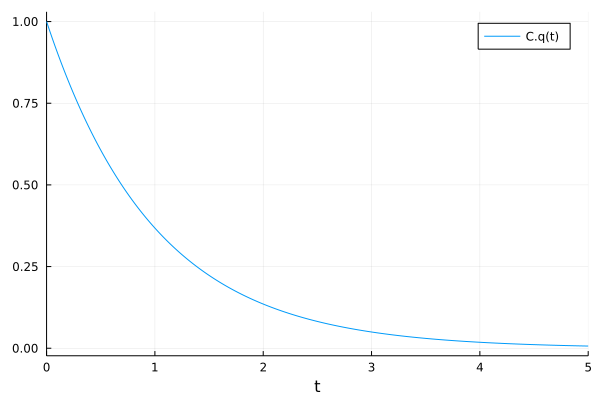

In [12]:
tspan = (0., 5.)
u0 = [1]
sol = simulate(model, tspan; u0)
plot(sol)

## Adding a forcing function
We will expand our model by adding an external forcing function, represented by the component `Sf`

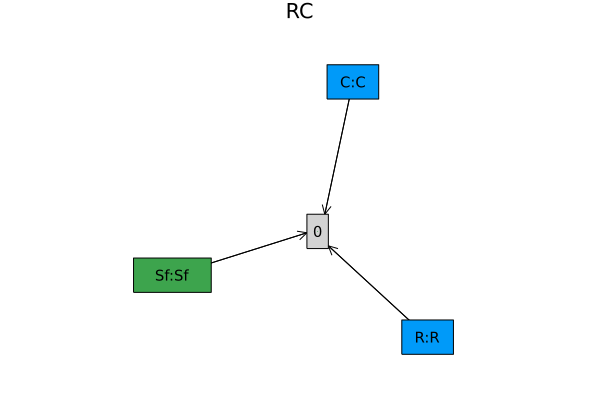

In [13]:
Sf = Component(:Sf)
add_node!(model, Sf)
connect!(model, Sf, zero_law)
plot(model, fontsize = 10)

The simplest way to add an external input is to add a constant e.g. `f(t) = 2`. Note the additional '2' in the equation below

In [14]:
Sf.fs = t -> 2
constitutive_relations(model)

1-element Vector{Equation}:
 Differential(t)(C₊q(t)) ~ (2.0C₊C*R₊R - C₊q(t)) / (C₊C*R₊R)

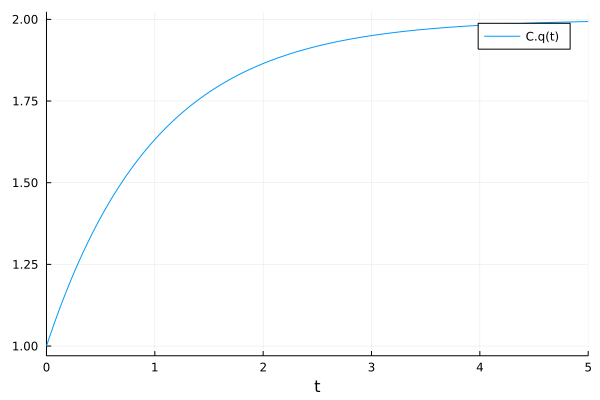

In [15]:
sol = simulate(model, tspan; u0)
plot(sol)

The forcing function can be more complex, such as `f(t) = sin(2t)`

In [16]:
Sf.fs = t -> sin(2t)
constitutive_relations(model)

1-element Vector{Equation}:
 Differential(t)(C₊q(t)) ~ (C₊C*R₊R*sin(2t) - C₊q(t)) / (C₊C*R₊R)

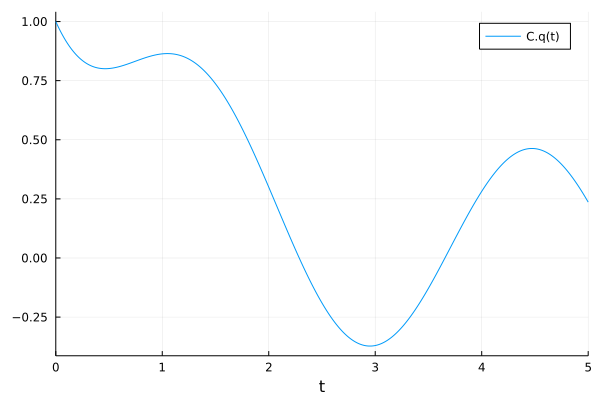

In [17]:
sol = simulate(model, tspan; u0)
plot(sol)

The function `f(t)` can be any arbitrary julia function of t, so long as it returns a sensible output. Note that for this to work you must register the custom function with `@register_symbolic`, so that the library knows not to simplify this function further. Note the addition of `f(t)` in the equation.

In [18]:
f(t) = t % 1 <= 0.5 ? 0 : 1
@register_symbolic f(t)

Sf.fs = t -> f(t)
constitutive_relations(model)

1-element Vector{Equation}:
 Differential(t)(C₊q(t)) ~ (C₊C*R₊R*f(t) - C₊q(t)) / (C₊C*R₊R)

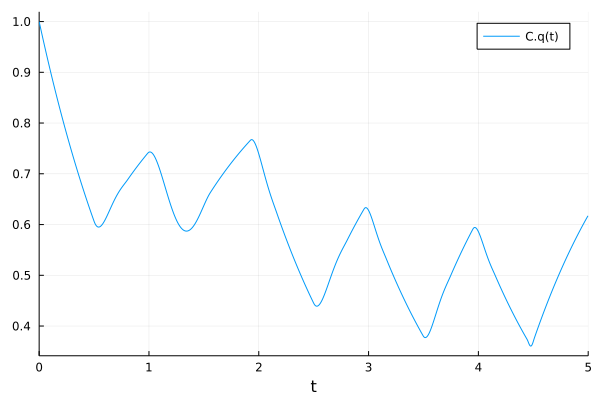

In [19]:
sol = simulate(model, tspan; u0)
plot(sol)

Once a function `f(t)` is registered in in the model, it can be repeatedly used and called without having to reconstruct the model!

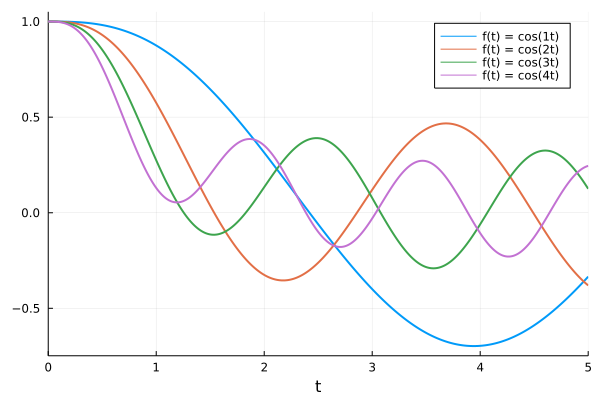

In [20]:
p = plot();
for i in 1:4
    f(t) = cos(i * t)
    sol = simulate(model, tspan; u0)
    plot!(p, sol, label = "f(t) = cos($(i)t)", lw=2)
end
plot(p)